In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin_slsqp
import qvalue as qv

In [2]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)




In [3]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [4]:
new_clinical.columns

Index(['Lymph nodes examined positive', 'Nottingham prognostic index',
       'Cellularity', 'Chemotherapy', 'Cohort', 'ER status measured by IHC',
       'HER2 status measured by SNP6', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster', 'Age at Diagnosis',
       'Overall Survival (Months)', 'Overall Survival Status',
       'Pam50 + Claudin-low subtype', '3-Gene classifier subtype',
       'Patient's Vital Status', 'Primary Tumor Laterality', 'Radio Therapy',
       'Tumor Other Histologic Subtype', 'Type of Breast Surgery',
       'Sample Identifier', 'Cancer Type', 'Cancer Type Detailed', 'ER Status',
       'HER2 Status', 'Neoplasm Histologic Grade', 'Oncotree Code',
       'PR Status', 'Sample Type', 'Tumor Size', 'Tumor Stage', 'Triple Neg',
       'ER-/PR-/HER2+'],
      dtype='object')

In [5]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)
for i in full_df['Pam50 + Claudin-low subtype'].unique():
    if type(i) == str:
        full_df[f'PAM50 {i} or not'] = full_df.apply(lambda row: i if (row['Pam50 + Claudin-low subtype'] == i) else 'Not', axis = 1)

In [6]:
full_df

,Interleukin-6 signaling,Apoptosis,Hemostasis,Intrinsic Pathway for Apoptosis,PKB-mediated events,PI3K Cascade,MAPK3 (ERK1) activation,Translesion synthesis by REV1,Translesion synthesis by Y family DNA polymerases bypasses lesions on DNA template,Recognition of DNA damage by PCNA-containing replication complex,...,Tumor Stage,Triple Neg,ER-/PR-/HER2+,PAM50 LumA or not,PAM50 LumB or not,PAM50 Her2 or not,PAM50 Normal or not,PAM50 Basal or not,PAM50 claudin-low or not,PAM50 NC or not
MB-0002,-0.464915,1.150390,7.995550,-2.133505,-1.005971,-1.934175,0.682674,-1.740452,-1.758971,2.306896,...,1,False,False,LumA,Not,Not,Not,Not,Not,Not
MB-0008,1.135676,-5.398171,-1.468534,-2.783638,-0.042169,-1.152715,-0.440677,-0.738142,-0.950279,0.857385,...,2,False,False,Not,LumB,Not,Not,Not,Not,Not
MB-0010,-0.016407,-2.252856,1.688631,-1.840132,0.439943,0.907014,-0.946115,-1.195843,-2.019880,2.452047,...,4,False,False,Not,LumB,Not,Not,Not,Not,Not
MB-0035,-0.045984,3.050125,14.221321,-1.010664,-2.460802,0.033379,-0.040401,1.589719,0.338310,-0.025657,...,2,False,False,Not,Not,Her2,Not,Not,Not,Not
MB-0036,-1.107911,1.445771,5.790792,1.275586,-1.040463,-2.897256,0.357232,0.276760,1.075780,-1.226257,...,4,False,False,LumA,Not,Not,Not,Not,Not,Not
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-7295,-0.097627,-4.277540,-5.748505,-3.180437,-0.865192,-0.979926,-1.582625,-0.735149,-0.468519,0.321434,...,NaN,False,False,LumA,Not,Not,Not,Not,Not,Not
MB-7296,-0.616957,-4.852698,1.617394,-3.523299,-1.540831,1.360917,-0.889991,-1.775554,-2.728289,1.738995,...,NaN,False,False,Not,LumB,Not,Not,Not,Not,Not
MB-7297,-0.546331,-8.314218,-2.774328,-2.203446,-0.507499,-0.153017,-0.957462,-0.821364,-1.953621,2.779270,...,NaN,False,False,Not,LumB,Not,Not,Not,Not,Not
MB-7298,1.160625,-6.085674,-3.616640,-2.815058,-0.101404,-0.417562,-1.730290,0.260045,0.183894,-0.057154,...,NaN,False,False,Not,LumB,Not,Not,Not,Not,Not


In [7]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import qvalue as qv

clusterframes = {}


for i in full_df['Pam50 + Claudin-low subtype'].unique():
    if type(i) == str:
        df_cluster = pd.DataFrame(index=pca_per_pathway.columns) 
        pvaluelist = []
        for pathway in df_cluster.index:
            results = ols("Q(pathway) ~ C(Q(f'PAM50 {i} or not'))", data=full_df).fit()
            table = sm.stats.anova_lm(results, typ=2)
            pvalue = table['PR(>F)'][0]
            pvaluelist.append(pvalue)
    
        df_cluster['p-values'] = pvaluelist
        qv.qvalues(df_cluster, 'p-values', 'qvalues')
        print(i)
        clusterframes[i] = df_cluster

LumA
LumB
Her2
Normal
Basal
claudin-low
NC


In [8]:
significant_pathways = {}
def failures_of_null(cluster, my_xa, my_xb, iterations=10000):
    pvalues = clusterframes[cluster]['p-values'].tolist()
    pvalues = [1e-320 if x == 0.0 else x for x in pvalues]##p = 0 gives error so setting it to 1e-320
    pvalues = [0.999 if x == 1.0 else x for x in pvalues] ##pathways with p-val 1 gave error as range would be to inf
    pvalues = sorted(pvalues)
    z_scores = norm.ppf(pvalues)
    print(z_scores)
    xa = np.percentile(z_scores, my_xa)
    xb = np.percentile(z_scores, my_xb)
    print(f'Quantiles calculated: {xa}, {xb}')


    trunc_z = z_scores[z_scores>xa]
    trunc_z = trunc_z[trunc_z<xb]

    def func(p, r, xa, xb):
        return truncnorm.nnlf(p, r)

    def constraint(p, r, xa, xb):
        a, b, loc, scale = p
        return np.array([a*scale + loc - xa, b*scale + loc - xb])

    loc_guess = np.median(z_scores)
    scale_guess = np.std(z_scores)
    a_guess = (xa - loc_guess)/scale_guess
    b_guess = (xb - loc_guess)/scale_guess
    p0 = [a_guess, b_guess, loc_guess, scale_guess]

    par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=iterations)
    print(par)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.hist(z_scores, bins=50, density=True)
    ax.plot(z_scores, truncnorm.pdf(z_scores, par[0], par[1], par[2], par[3]), 'r-', lw=5, alpha=0.6, label='truncnorm pdf')
    ax.plot(z_scores, norm.pdf(z_scores, par[2], par[3]), 'g-', lw=5, alpha=0.6, label='norm pdf')
    #ax.plot(z_scores, norm.sf(abs(z_scores-par[2]), 0, par[3]), 'y-', lw=5, alpha=0.6, label='norm sf')
    ax.legend(loc='best')
    plt.show()

    p_vals = norm.sf(abs(z_scores-par[2]), 0, par[3])

    plt.figure(figsize=(15, 10))
    plt.hist(p_vals, bins=30, density=True)
    plt.show()
    #print(pvalues[:10])
    print(p_vals[:20])
    sig_pathways = p_vals[p_vals < 0.001].size
    significant_pathways[cluster] = sig_pathways
    print(f'number of pathways with p < 0.001: {p_vals[p_vals < 0.001].size}')
    
    
    ##let's add to clusterframes
    clusterframes[cluster]['adjusted p-value'] = p_vals
    qv.qvalues(clusterframes[cluster], 'adjusted p-value', 'adjusted q-values')
    
    ##and log fold change
    clusterframes[cluster]['log adjusted p-value'] = -np.log10(clusterframes[cluster]['adjusted p-value'])
    clusterframes[cluster][f'{cluster} log adjusted q-value'] = -np.log10(clusterframes[cluster]['adjusted q-values'])

[-25.48927568 -25.41604795 -25.38784762 ...   2.7017421    2.7018321
   2.88450034]
Quantiles calculated: -9.592329540958696, 1.2536113780399734
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3226.108924481696
            Iterations: 51
            Function evaluations: 372
            Gradient evaluations: 51
[-1.3303827   1.18038904 -3.84539049  4.31976381]


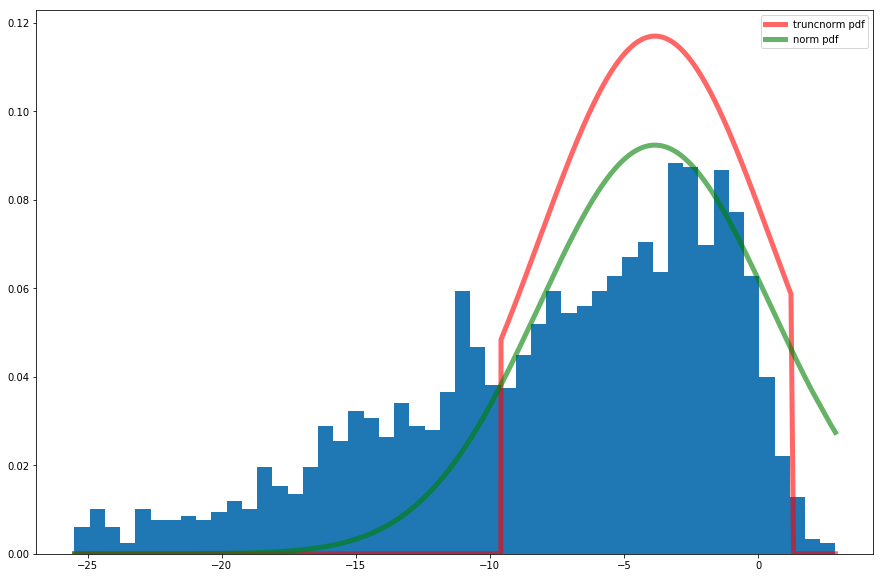

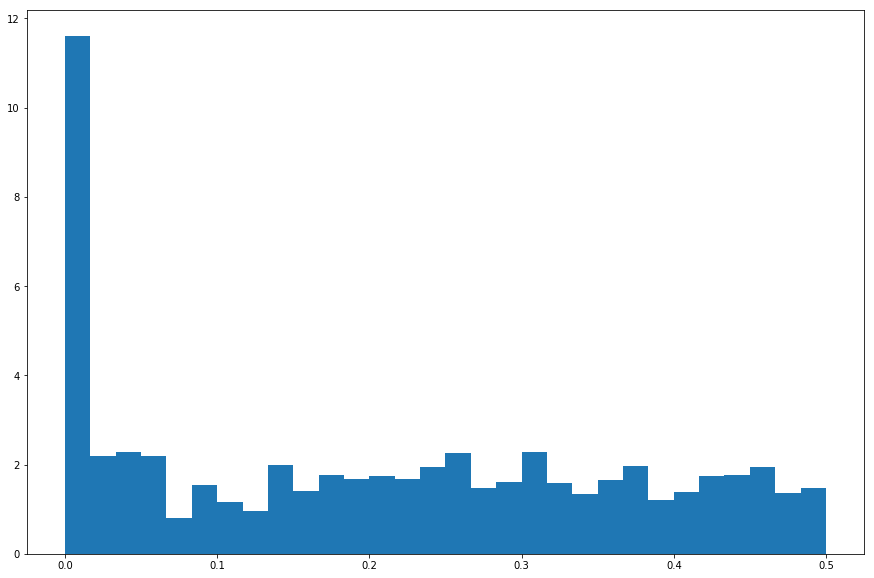

[2.71539152e-07 2.96503477e-07 3.06695612e-07 3.90717525e-07
 4.49832117e-07 4.67612462e-07 5.32704532e-07 5.43202218e-07
 5.43202483e-07 6.04423165e-07 6.85378730e-07 7.25968911e-07
 8.63344323e-07 8.70042592e-07 9.08545266e-07 9.73504527e-07
 9.76972752e-07 9.82935566e-07 9.96217935e-07 1.07834926e-06]
number of pathways with p < 0.001: 166


In [9]:
failures_of_null('LumA', 33, 99)

[-24.01331707 -23.89694362 -19.96698982 ...   2.22153566   2.32204318
   2.49938316]
Quantiles calculated: -6.671687225781293, 2.2134251197289148
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2635.342652927038
            Iterations: 99
            Function evaluations: 746
            Gradient evaluations: 99
[-1.19579233  1.76948153 -3.0886289   2.99638845]


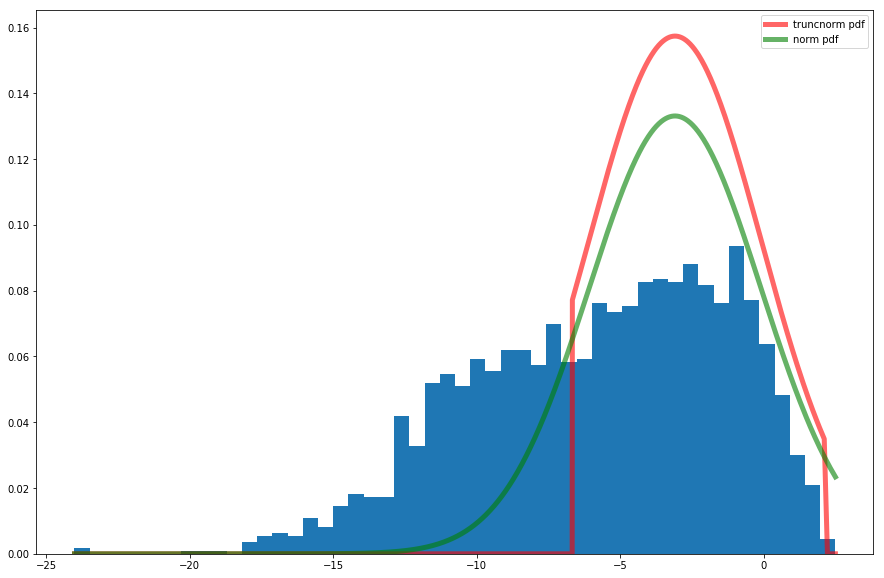

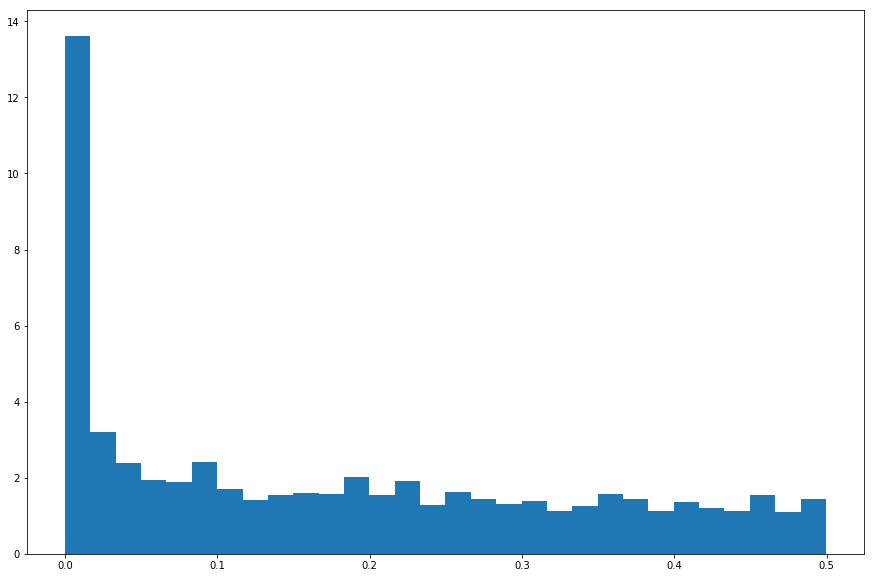

[1.44159914e-12 1.89948616e-12 8.86013500e-09 2.03233088e-08
 4.70418437e-08 2.79107242e-07 3.36802883e-07 4.39749308e-07
 5.62423569e-07 8.98480575e-07 9.44008379e-07 9.97123655e-07
 1.16623513e-06 1.23380801e-06 1.29143023e-06 1.61204836e-06
 1.95059439e-06 2.00844750e-06 2.34998554e-06 2.75075537e-06]
number of pathways with p < 0.001: 169


In [17]:
failures_of_null('LumB', 40, 99.9)

[-30.82418042 -30.8241804  -28.9850336  ...   1.82642429   2.06365973
   2.78994713]
Quantiles calculated: -10.916604956036114, 2.6393877497864975
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3922.0263566403346
            Iterations: 93
            Function evaluations: 696
            Gradient evaluations: 93
[-1.70598791  1.80694849 -4.33340588  3.85887792]


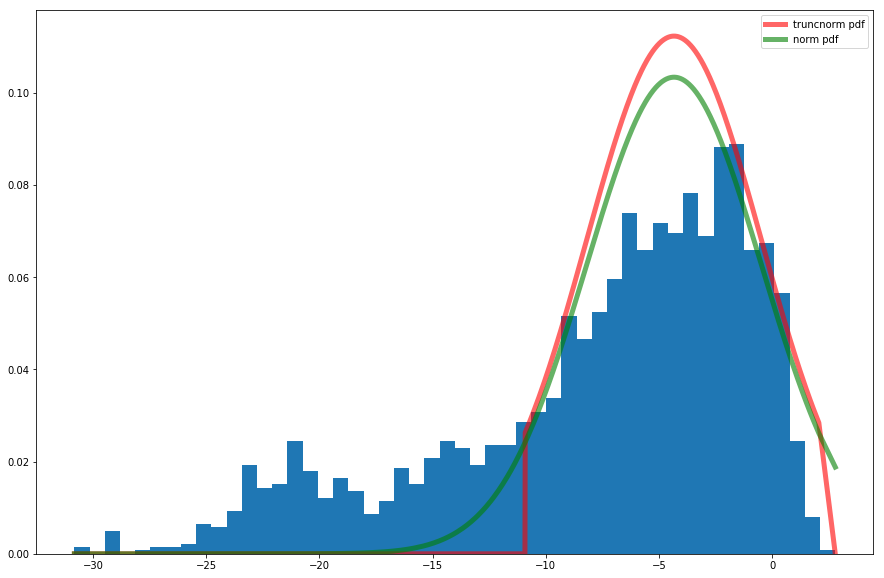

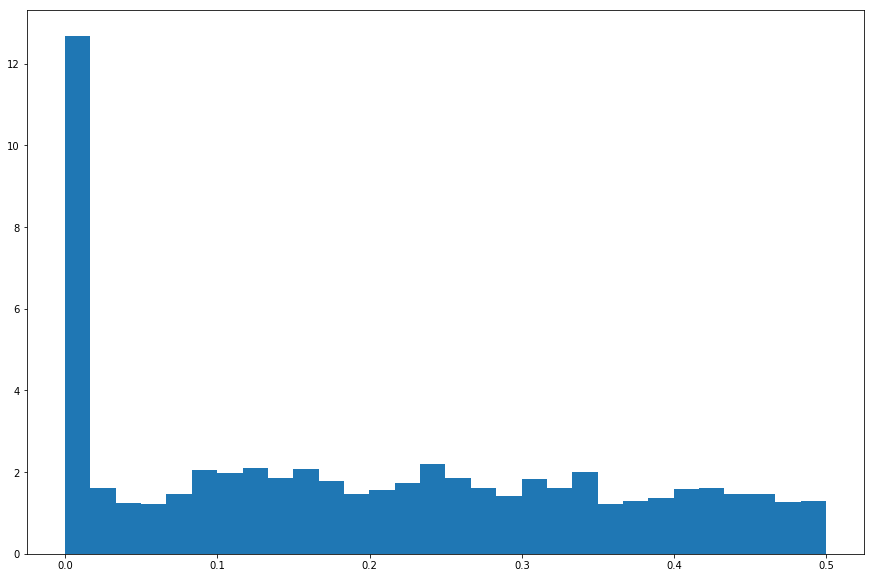

[3.32711289e-12 3.32711302e-12 8.38759958e-11 9.37503400e-11
 1.01423658e-10 1.01423944e-10 1.01423973e-10 1.01424103e-10
 1.01424303e-10 6.16504148e-10 1.23700646e-09 1.23885430e-09
 4.62830287e-09 4.96180099e-09 1.10732038e-08 1.10932845e-08
 1.80627871e-08 2.38526841e-08 2.45967758e-08 2.52128031e-08]
number of pathways with p < 0.001: 279


In [11]:
failures_of_null('Basal', 25, 99.99)

In [12]:
clusterframes.keys()

dict_keys(['LumA', 'LumB', 'Her2', 'Normal', 'Basal', 'claudin-low', 'NC'])

[-20.2784599  -18.25485454 -18.24815901 ...   2.5987441    2.63518565
   3.90098927]
Quantiles calculated: -4.855370059728224, 1.612310489535607
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2243.6002970974137
            Iterations: 70
            Function evaluations: 513
            Gradient evaluations: 70
[-1.12097626  1.46243508 -2.04895815  2.50354269]


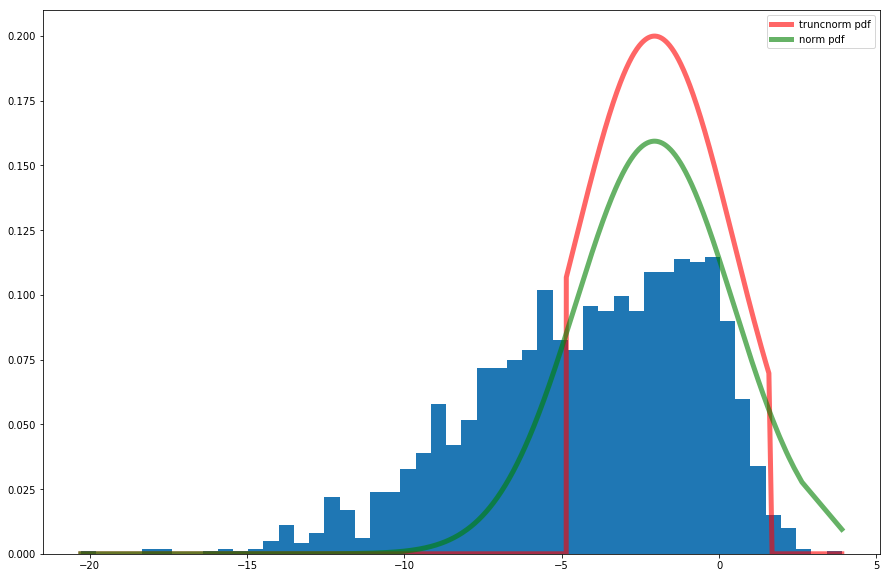

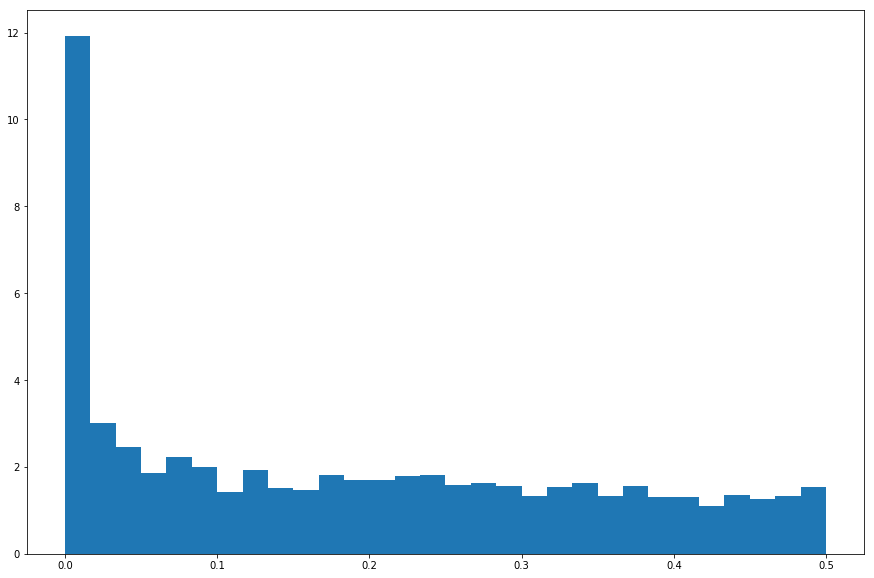

[1.65085995e-13 4.79789912e-11 4.88359742e-11 2.21913513e-10
 2.46629966e-10 6.76273493e-09 2.60476236e-08 2.77091098e-08
 7.05355786e-08 2.29302173e-07 3.36434855e-07 4.46821787e-07
 5.29673762e-07 6.38077168e-07 7.26990339e-07 9.15631551e-07
 1.00983284e-06 1.20685353e-06 1.22909180e-06 1.25834988e-06]
number of pathways with p < 0.001: 155


In [18]:
failures_of_null('Her2', 40, 99)

[-16.88509332 -14.47393474 -13.84685231 ...   2.42925125   2.44068299
   2.72576306]
Quantiles calculated: -4.532482606065018, 1.772633742076185
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2730.3297866389903
            Iterations: 31
            Function evaluations: 220
            Gradient evaluations: 31
[-1.40572909  1.73973987 -1.714688    2.00450758]


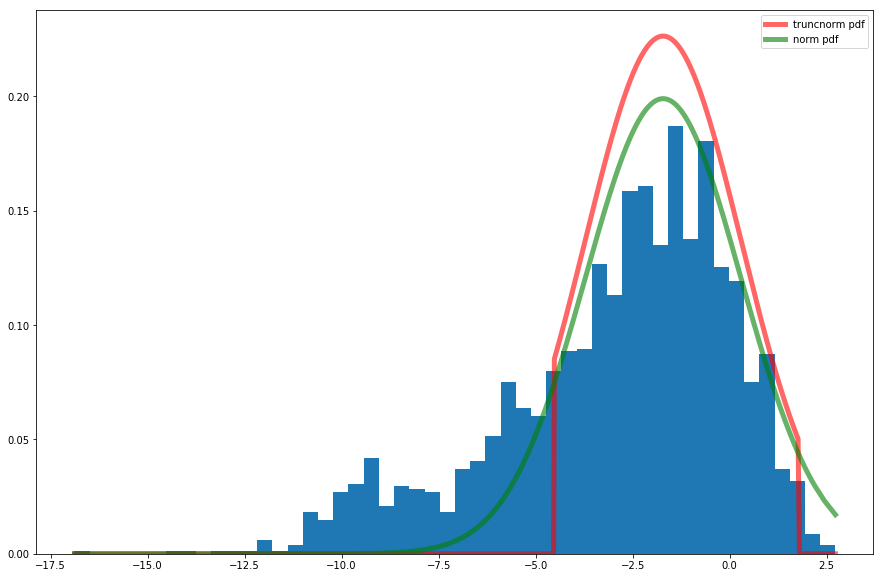

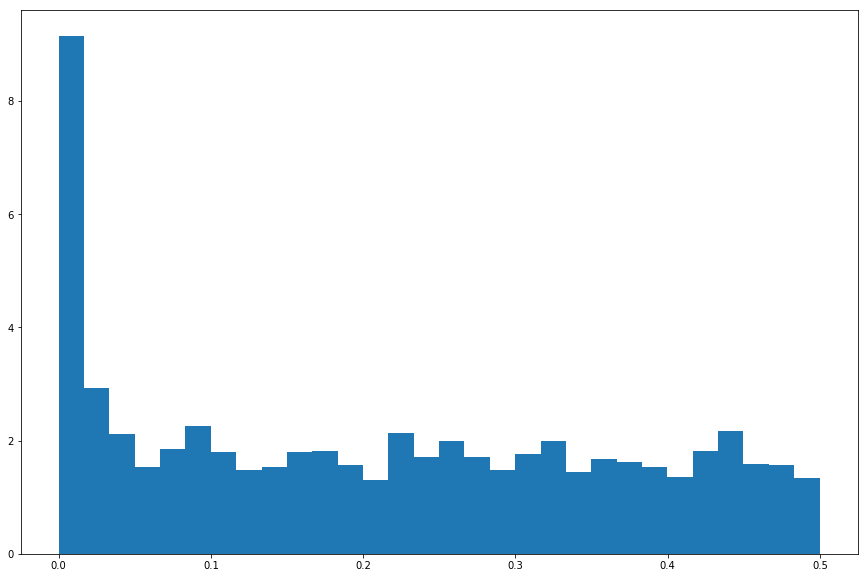

[1.89294681e-14 9.74685632e-11 7.13335264e-10 3.61606315e-09
 1.12202422e-08 7.71630182e-08 1.02844313e-07 1.13856817e-07
 1.90095705e-07 2.12378495e-07 2.40278495e-07 4.49799744e-07
 8.34059686e-07 1.00142308e-06 1.34490849e-06 1.83113733e-06
 2.18536871e-06 2.27491055e-06 2.45386456e-06 2.49285324e-06]
number of pathways with p < 0.001: 183


In [14]:
failures_of_null('Normal', 25, 99)

[-29.24610709 -28.71623777 -28.60647003 ...   2.19046959   2.49176525
   2.5680416 ]
Quantiles calculated: -5.635536984306563, 2.1858318506188668
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1612.5853621067276
            Iterations: 237
            Function evaluations: 1875
            Gradient evaluations: 237
[-1.18439627  2.10933262 -2.82304076  2.37462436]


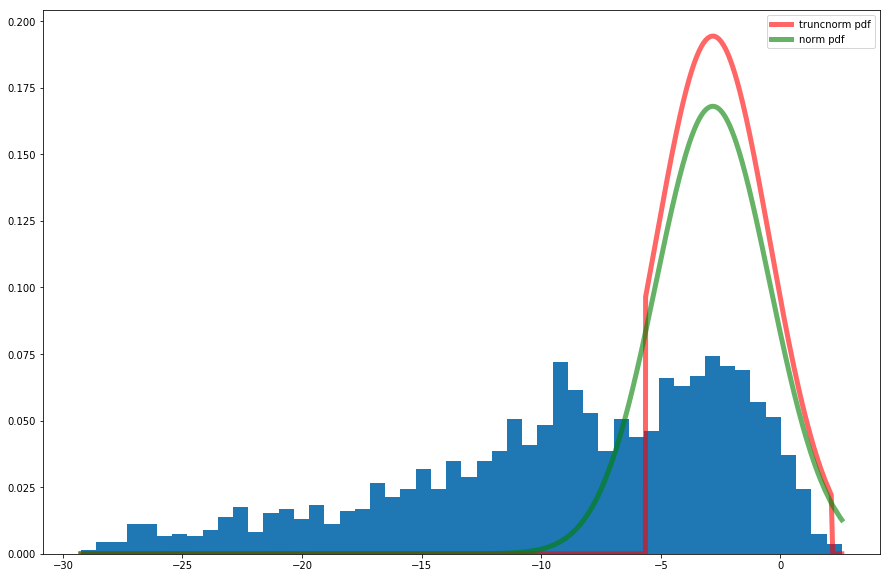

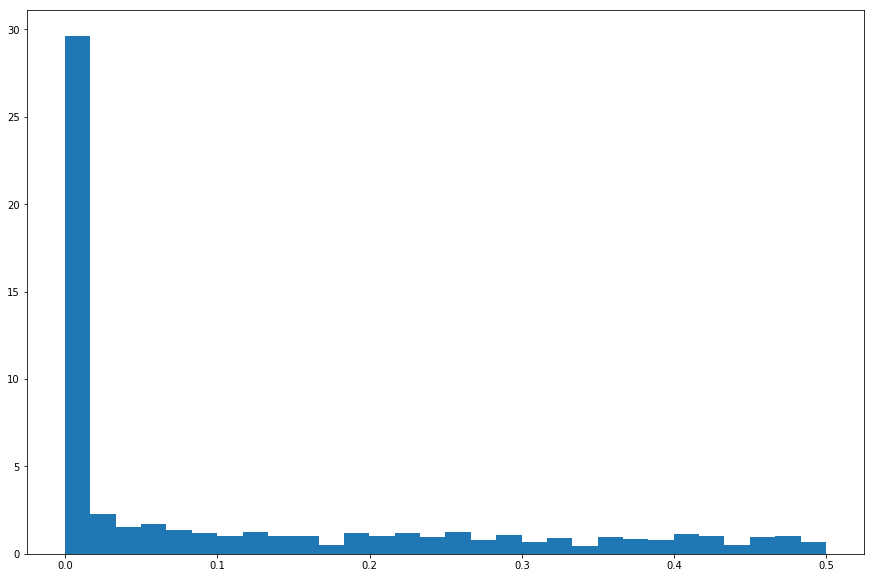

[4.62158025e-29 5.50749066e-28 9.14554203e-28 2.08768997e-27
 4.20272963e-27 6.74910018e-27 6.98544257e-27 9.95235340e-27
 1.73344633e-26 2.58489307e-26 9.17397535e-26 1.41391009e-25
 1.63722332e-25 1.65554467e-25 3.23846199e-25 3.49037432e-25
 4.72993018e-25 7.24778952e-25 8.86403125e-25 1.20267598e-24]
number of pathways with p < 0.001: 745


In [21]:
failures_of_null('claudin-low', 60, 99.9)

[-3.94387644 -3.59669857 -3.13131202 ...  3.04360544  3.3523247
  3.38379665]
Quantiles calculated: -1.4328407199260171, 0.3165788749060048
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 615.5302285330254
            Iterations: 174
            Function evaluations: 1337
            Gradient evaluations: 174
[-0.98731486  1.26892483 -0.66730682  0.77536957]


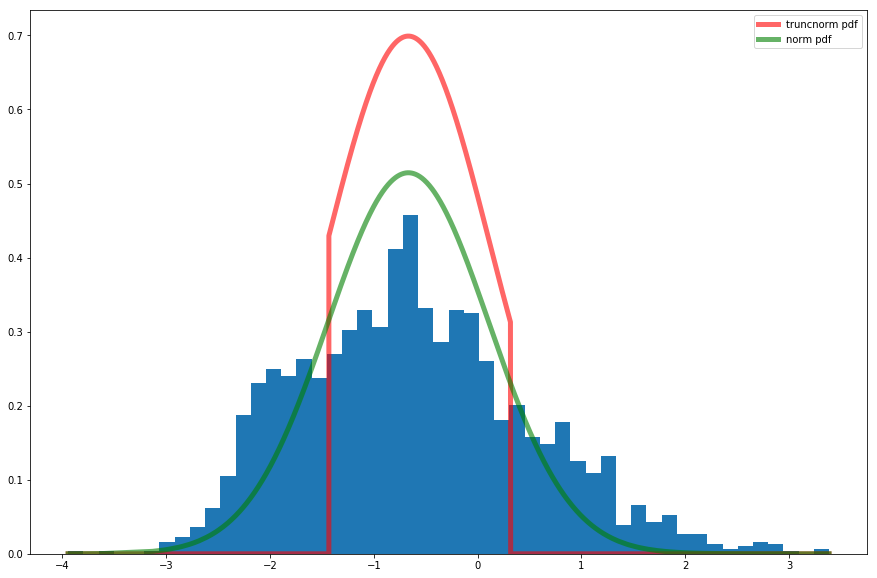

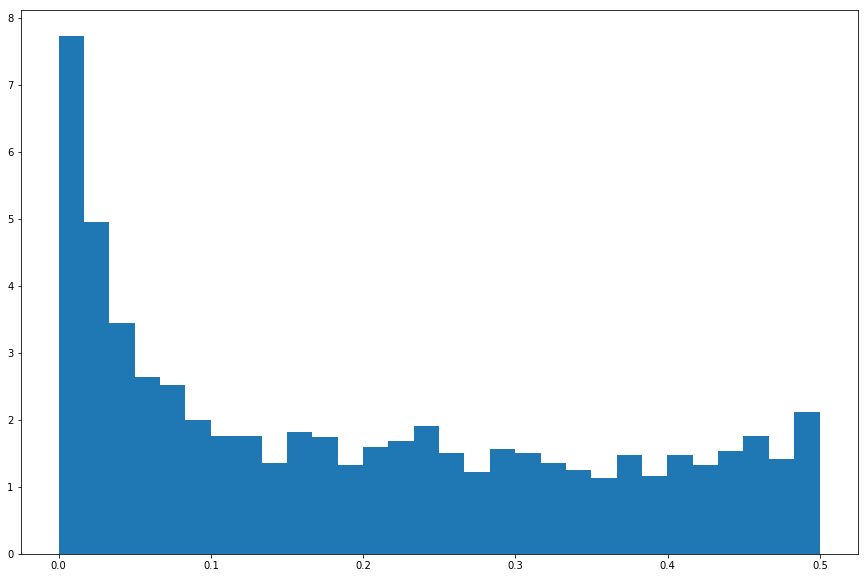

[1.19037899e-05 7.90278128e-05 7.41867278e-04 9.96580048e-04
 1.15090745e-03 1.17931218e-03 1.36473923e-03 1.44667686e-03
 1.91338097e-03 1.98948895e-03 2.17424536e-03 2.52180254e-03
 2.95386361e-03 2.99070596e-03 3.24558490e-03 3.39204134e-03
 3.85956742e-03 3.85959559e-03 4.07516270e-03 4.29241273e-03]
number of pathways with p < 0.001: 60


In [16]:
failures_of_null('NC', 25, 80)

In [22]:
clusterframes['claudin-low']

,p-values,qvalues,adjusted p-value,adjusted q-values,log adjusted p-value,claudin-low log adjusted q-value
PI3K/AKT Signaling in Cancer,2.516218e-188,5.218636e-185,4.621580e-29,9.585157e-26,28.335210,25.018401
Rho GTPase cycle,1.196183e-181,1.240442e-178,5.507491e-28,5.711268e-25,27.259046,24.243267
Hemostasis,2.791177e-180,1.929634e-177,9.145542e-28,6.322618e-25,27.038791,24.199103
Class A/1 (Rhodopsin-like receptors),4.711830e-178,2.443084e-175,2.087690e-27,1.082467e-24,26.680334,23.965585
Constitutive Signaling by Aberrant PI3K in Cancer,3.651012e-176,1.514440e-173,4.202730e-27,1.743292e-24,26.376469,23.758630
...,...,...,...,...,...,...
Fatty acids,6.212311e-10,1.071017e-09,4.970319e-01,4.979924e-01,0.303616,0.302777
Signaling by Insulin receptor,6.217540e-16,1.276750e-15,4.977958e-01,4.983245e-01,0.302949,0.302488
Formation of RNA Pol II elongation complex,1.464874e-04,2.042782e-04,4.978439e-01,4.983245e-01,0.302907,0.302488
E2F mediated regulation of DNA replication,1.387034e-04,1.937177e-04,4.982216e-01,4.984620e-01,0.302577,0.302368


In [25]:
full_clusterframe = pd.DataFrame(index=clusterframes['LumA'].index)
full_clusterframe
for i in clusterframes:
    print(type(i))
    series = clusterframes[i][f'{i} log adjusted q-value']
    full_clusterframe = pd.concat([full_clusterframe, series.reindex(full_clusterframe.index)], axis=1)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [26]:
full_clusterframe

,LumA log adjusted q-value,LumB log adjusted q-value,Her2 log adjusted q-value,Normal log adjusted q-value,Basal log adjusted q-value,claudin-low log adjusted q-value,NC log adjusted q-value
RHO GTPases Activate Formins,3.963590,0.995465,1.163591,3.021927,5.422721,0.350258,0.370020
Factors involved in megakaryocyte development and platelet production,3.963590,1.023093,1.955168,2.881715,4.784309,2.380233,0.477934
RHO GTPase Effectors,3.963590,1.133937,0.803294,3.095910,4.750884,0.378365,0.377144
EML4 and NUDC in mitotic spindle formation,3.963590,1.287602,1.161360,3.165939,4.931946,1.461865,0.363822
Kinesins,3.963590,1.424705,1.461955,2.855323,4.386029,2.627870,0.875957
...,...,...,...,...,...,...,...
Role of ABL in ROBO-SLIT signaling,0.301409,2.976070,0.996696,1.528871,0.357934,0.430449,0.438302
Transcriptional regulation of granulopoiesis,0.301409,1.641689,0.365430,0.350232,0.410021,1.068906,0.307644
Clathrin-mediated endocytosis,0.301409,0.555611,1.115075,0.337099,0.485192,2.443459,0.755875
STAT5 Activation,0.301293,1.025219,0.680057,0.654833,0.357934,5.119556,0.435355


In [27]:
full_clusterframe.to_csv('../exp/adjusted_distributions_PAM50.csv')